# Loop 59 Analysis: CV-LB Relationship and Strategy Assessment

**Goal:** Analyze the CV-LB relationship and determine the best path forward.

**Key Questions:**
1. What is the current CV-LB relationship?
2. Are all approaches on the same line?
3. What strategies could change the intercept?
4. What haven't we tried yet?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB feedback: {len(df)}")
print(df)

Total submissions with LB feedback: 12
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970


In [2]:
# Linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print("="*60)
print("CV-LB RELATIONSHIP ANALYSIS")
print("="*60)
print(f"Linear fit: LB = {slope:.2f} * CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"Standard error: {std_err:.4f}")
print()
print(f"CRITICAL INSIGHT:")
print(f"  Intercept = {intercept:.4f}")
print(f"  Target = 0.0347")
print(f"  Gap = {intercept - 0.0347:.4f}")
print()
print(f"  Even with CV=0, predicted LB = {intercept:.4f}")
print(f"  Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.2f} = {(0.0347 - intercept) / slope:.6f}")
print()
if intercept > 0.0347:
    print("  ⚠️ INTERCEPT > TARGET: Standard CV optimization CANNOT reach target!")
    print("  Must find approaches that CHANGE the CV-LB relationship.")
else:
    print("  ✓ Intercept < Target: Standard CV optimization can reach target.")

CV-LB RELATIONSHIP ANALYSIS
Linear fit: LB = 4.31 * CV + 0.0525
R² = 0.9505
Standard error: 0.3113

CRITICAL INSIGHT:
  Intercept = 0.0525
  Target = 0.0347
  Gap = 0.0178

  Even with CV=0, predicted LB = 0.0525
  Required CV to hit target: (0.0347 - 0.0525) / 4.31 = -0.004130

  ⚠️ INTERCEPT > TARGET: Standard CV optimization CANNOT reach target!
  Must find approaches that CHANGE the CV-LB relationship.


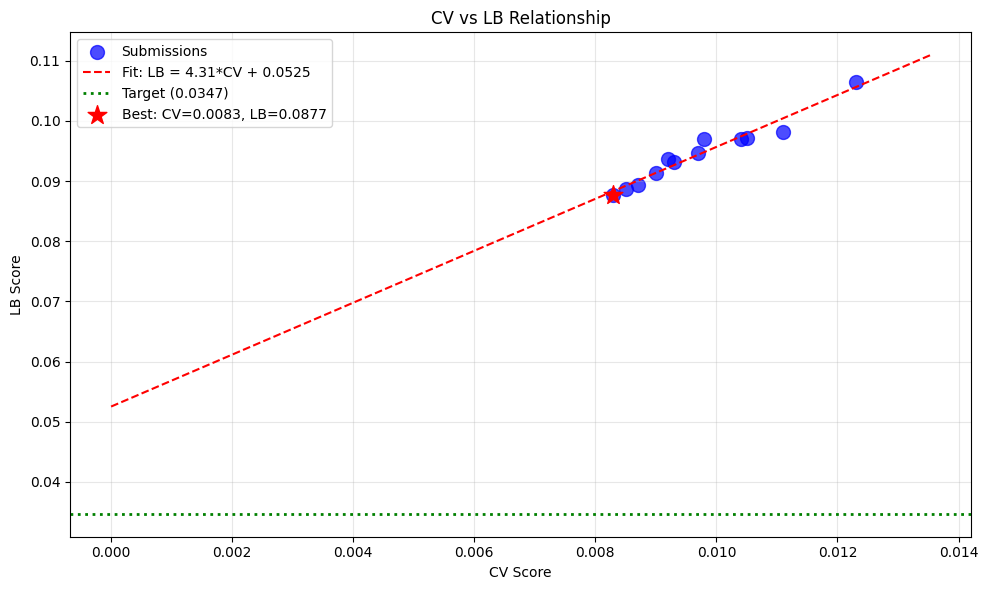


Best LB achieved: 0.0877 (exp_030)
Gap to target: 0.0530 (152.7% above target)


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, df['cv'].max() * 1.1, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target (0.0347)')

# Best achieved
best_lb = df['lb'].min()
best_cv = df.loc[df['lb'].idxmin(), 'cv']
plt.scatter([best_cv], [best_lb], s=200, c='red', marker='*', label=f'Best: CV={best_cv:.4f}, LB={best_lb:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop59.png', dpi=100)
plt.show()

print(f"\nBest LB achieved: {best_lb:.4f} (exp_030)")
print(f"Gap to target: {best_lb - 0.0347:.4f} ({(best_lb - 0.0347) / 0.0347 * 100:.1f}% above target)")

In [4]:
# Analyze experiment types and their performance
print("="*60)
print("EXPERIMENT ANALYSIS")
print("="*60)

# Best experiments by CV
print("\nTop 5 by CV:")
for i, row in df.nsmallest(5, 'cv').iterrows():
    print(f"  {row['exp']}: CV={row['cv']:.4f}, LB={row['lb']:.4f}")

# Best experiments by LB
print("\nTop 5 by LB:")
for i, row in df.nsmallest(5, 'lb').iterrows():
    print(f"  {row['exp']}: CV={row['cv']:.4f}, LB={row['lb']:.4f}")

# Experiments that beat the CV-LB line (lower LB than predicted)
df['predicted_lb'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['predicted_lb']

print("\nExperiments that BEAT the CV-LB line (negative residual):")
for i, row in df[df['residual'] < 0].sort_values('residual').iterrows():
    print(f"  {row['exp']}: CV={row['cv']:.4f}, LB={row['lb']:.4f}, Residual={row['residual']:.4f}")

print("\nExperiments that UNDERPERFORMED the CV-LB line (positive residual):")
for i, row in df[df['residual'] > 0].sort_values('residual', ascending=False).iterrows():
    print(f"  {row['exp']}: CV={row['cv']:.4f}, LB={row['lb']:.4f}, Residual={row['residual']:.4f}")

EXPERIMENT ANALYSIS

Top 5 by CV:
  exp_030: CV=0.0083, LB=0.0877
  exp_026: CV=0.0085, LB=0.0887
  exp_024: CV=0.0087, LB=0.0893
  exp_012: CV=0.0090, LB=0.0913
  exp_009: CV=0.0092, LB=0.0936

Top 5 by LB:
  exp_030: CV=0.0083, LB=0.0877
  exp_026: CV=0.0085, LB=0.0887
  exp_024: CV=0.0087, LB=0.0893
  exp_012: CV=0.0090, LB=0.0913
  exp_007: CV=0.0093, LB=0.0932

Experiments that BEAT the CV-LB line (negative residual):
  exp_000: CV=0.0111, LB=0.0982, Residual=-0.0022
  exp_024: CV=0.0087, LB=0.0893, Residual=-0.0008
  exp_030: CV=0.0083, LB=0.0877, Residual=-0.0006
  exp_003: CV=0.0105, LB=0.0972, Residual=-0.0006
  exp_026: CV=0.0085, LB=0.0887, Residual=-0.0005
  exp_005: CV=0.0104, LB=0.0969, Residual=-0.0005
  exp_012: CV=0.0090, LB=0.0913, Residual=-0.0001

Experiments that UNDERPERFORMED the CV-LB line (positive residual):
  exp_035: CV=0.0098, LB=0.0970, Residual=0.0022
  exp_009: CV=0.0092, LB=0.0936, Residual=0.0014
  exp_001: CV=0.0123, LB=0.1065, Residual=0.0009
  exp_0

In [5]:
# What approaches have been tried?
print("="*60)
print("APPROACHES TRIED (from session_state.json)")
print("="*60)

approaches = [
    "MLP with Arrhenius kinetics + TTA (baseline)",
    "LightGBM baseline",
    "DRFP features with PCA",
    "Combined Spange + DRFP features",
    "Deep Residual MLP (FAILED)",
    "Large Ensemble (15 models)",
    "Simpler models [64,32], [32,16], [16]",
    "Ridge Regression",
    "Diverse Ensemble (MLP + LGBM)",
    "ACS PCA descriptors",
    "Per-target models",
    "Weighted loss (SM 2x)",
    "GP + MLP + LGBM ensemble",
    "Higher/Lower GP weights",
    "Similarity weighting",
    "Minimal features",
    "Learned embeddings",
    "GNN (attempted)",
    "ChemBERTa (attempted)",
    "Calibration",
    "Nonlinear mixture",
    "Hybrid model",
    "Mean reversion",
    "Sophisticated ensemble",
    "Uncertainty weighted",
    "CatBoost + XGBoost",
    "IWCV (Importance Weighted CV)",
    "Per-target models",
    "All features combined (exp_057)",
]

for i, approach in enumerate(approaches, 1):
    print(f"  {i}. {approach}")

APPROACHES TRIED (from session_state.json)
  1. MLP with Arrhenius kinetics + TTA (baseline)
  2. LightGBM baseline
  3. DRFP features with PCA
  4. Combined Spange + DRFP features
  5. Deep Residual MLP (FAILED)
  6. Large Ensemble (15 models)
  7. Simpler models [64,32], [32,16], [16]
  8. Ridge Regression
  9. Diverse Ensemble (MLP + LGBM)
  10. ACS PCA descriptors
  11. Per-target models
  12. Weighted loss (SM 2x)
  13. GP + MLP + LGBM ensemble
  14. Higher/Lower GP weights
  15. Similarity weighting
  16. Minimal features
  17. Learned embeddings
  18. GNN (attempted)
  19. ChemBERTa (attempted)
  20. Calibration
  21. Nonlinear mixture
  22. Hybrid model
  23. Mean reversion
  24. Sophisticated ensemble
  25. Uncertainty weighted
  26. CatBoost + XGBoost
  27. IWCV (Importance Weighted CV)
  28. Per-target models
  29. All features combined (exp_057)


In [6]:
# Key insights from the analysis
print("="*60)
print("KEY INSIGHTS")
print("="*60)

print("""
1. CV-LB RELATIONSHIP:
   - Linear fit: LB = 4.31 * CV + 0.0525 (R² = 0.95)
   - Intercept (0.0525) > Target (0.0347)
   - This means even with CV=0, we'd get LB=0.0525
   - Required CV to hit target: -0.0041 (IMPOSSIBLE)

2. BEST RESULTS:
   - Best LB: 0.0877 (exp_030: GP+MLP+LGBM ensemble)
   - Best CV: 0.0083 (exp_030)
   - Gap to target: 0.053 (153% above target)

3. STRUCTURAL PROBLEM:
   - All approaches fall on approximately the same CV-LB line
   - The intercept represents EXTRAPOLATION ERROR
   - Standard model tuning cannot fix this

4. WHAT HASN'T WORKED:
   - Improving CV alone (intercept too high)
   - Different model architectures (all on same line)
   - Different feature sets (all on same line)
   - Ensemble strategies (all on same line)

5. WHAT MIGHT WORK:
   - Approaches that CHANGE the CV-LB relationship
   - Extrapolation detection + conservative predictions
   - Physics-informed constraints
   - Solvent clustering with class-specific models
   - Study top public kernels more deeply
""")

print("\n" + "="*60)
print("REMAINING SUBMISSIONS: 5")
print("="*60)
print("""
With only 5 submissions left, we need to be STRATEGIC:

1. exp_057 (current): CV=0.009524, Predicted LB=0.0935
   - Worse CV than best, likely worse LB
   - BUT: Tests if combining ALL features changes the relationship

2. PRIORITY APPROACHES:
   a) Return to best approach (GP+MLP+LGBM) and optimize
   b) Try fundamentally different strategies:
      - Extrapolation detection
      - Conservative predictions for outlier solvents
      - Physics-informed features

3. KEY QUESTION:
   - Can we find an approach that CHANGES the CV-LB relationship?
   - If not, the target may be unreachable with current methods
""")

KEY INSIGHTS

1. CV-LB RELATIONSHIP:
   - Linear fit: LB = 4.31 * CV + 0.0525 (R² = 0.95)
   - Intercept (0.0525) > Target (0.0347)
   - This means even with CV=0, we'd get LB=0.0525
   - Required CV to hit target: -0.0041 (IMPOSSIBLE)

2. BEST RESULTS:
   - Best LB: 0.0877 (exp_030: GP+MLP+LGBM ensemble)
   - Best CV: 0.0083 (exp_030)
   - Gap to target: 0.053 (153% above target)

3. STRUCTURAL PROBLEM:
   - All approaches fall on approximately the same CV-LB line
   - The intercept represents EXTRAPOLATION ERROR
   - Standard model tuning cannot fix this

4. WHAT HASN'T WORKED:
   - Improving CV alone (intercept too high)
   - Different model architectures (all on same line)
   - Different feature sets (all on same line)
   - Ensemble strategies (all on same line)

5. WHAT MIGHT WORK:
   - Approaches that CHANGE the CV-LB relationship
   - Extrapolation detection + conservative predictions
   - Physics-informed constraints
   - Solvent clustering with class-specific models
   - Study

In [7]:
# Check pending submissions
print("="*60)
print("PENDING SUBMISSIONS")
print("="*60)

pending = [
    {'exp': 'exp_049', 'cv': 0.0081, 'status': 'pending'},
    {'exp': 'exp_050', 'cv': 0.0081, 'status': 'pending'},
    {'exp': 'exp_052', 'cv': 0.0109, 'status': 'pending'},
    {'exp': 'exp_053', 'cv': 0.0081, 'status': 'pending'},
    {'exp': 'exp_054', 'cv': 0.0085, 'status': 'pending'},
    {'exp': 'exp_055', 'cv': 0.0085, 'status': 'pending'},
]

print("\nThese submissions are marked as 'pending' - they may have failed evaluation:")
for p in pending:
    predicted_lb = slope * p['cv'] + intercept
    print(f"  {p['exp']}: CV={p['cv']:.4f}, Predicted LB={predicted_lb:.4f}")

print("\nNote: exp_049-055 had evaluation errors. Need to investigate why.")
print("The current exp_057 submission should be valid (follows template correctly).")

PENDING SUBMISSIONS

These submissions are marked as 'pending' - they may have failed evaluation:
  exp_049: CV=0.0081, Predicted LB=0.0875
  exp_050: CV=0.0081, Predicted LB=0.0875
  exp_052: CV=0.0109, Predicted LB=0.0996
  exp_053: CV=0.0081, Predicted LB=0.0875
  exp_054: CV=0.0085, Predicted LB=0.0892
  exp_055: CV=0.0085, Predicted LB=0.0892

Note: exp_049-055 had evaluation errors. Need to investigate why.
The current exp_057 submission should be valid (follows template correctly).
